In [1]:
# load packages
import itertools
from itertools import compress
import pdb

import time
from datetime import timedelta, datetime
from os.path import join
import os
from os import listdir
from os.path import isfile, join
import csv
from timeit import default_timer as timer

import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure
from matplotlib.ticker import PercentFormatter
%matplotlib inline


import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy
from scipy.signal import welch, decimate, periodogram, find_peaks
from scipy import signal
from scipy import stats
from scipy.stats import pearsonr, mannwhitneyu, spearmanr, ranksums, ttest_ind, f_oneway
from scipy.ndimage.filters import uniform_filter1d
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests
from statsmodels.multivariate.manova import MANOVA
from statistics import mode
import math  
import random 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict, cross_val_score, KFold, train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, auc, f1_score, precision_recall_curve
from sklearn.manifold import MDS
import seaborn as sns

import sys

In [3]:
# # Version check of used packages
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('SciPy:',scipy.__version__)
# Pandas: 1.1.3
# Numpy: 1.19.1
# SciPy: 1.5.2

Pandas: 1.1.3
Numpy: 1.19.1
SciPy: 1.5.2


In [4]:
# define path, working directory which contains filtered accelerometer files

# path="/Users/jeroenhabets/Desktop/radboud data/data/"
notebook_path = os.getcwd()
path = os.path.dirname(notebook_path)
# images_path = "/Users/jeroenhabets/Starr Lab Dropbox/jeroen habets/PHD werkmap/UCSF time/Sensor-project/analysis images/"

os.chdir(path)
print('Path and working directory defined as %s' %path)


Path and working directory defined as /Users/jeroenhabets/Research/pd_sensors/brady_reallife


# Real-life ON- vs OFF-bradykinesia detection using a wrist-accelerometer  - Patient population description and classification results (incl. significance and clinical correlations)

Prep: Loading in extracted accelerometer bradykinesia features (one value/ 60 seconds, medState 0 is pre-medication, 1 is post-medication), and outcomes from classification analyses.

Part 1: Descriptive statistics of population.

Part 2: Analyzing population for differences in medication-states based on 4 main features, using MANOVA + post-hoc ANOVA analyses.

Part 3: Comparing classification results with barplots (varying models and data inclusion approaches).

Part 4: Comparing classification results with equivalent plots.

Part 5: Correlating predictive performance with clinical characteristics.


## Preparation: Load clinical info, features, and classification reults
Previsouly filtered data is loaded in to dataframes per patient-side.

In [183]:
def loadUPDRSscores():
    '''
    Input:
    Load in existing updrsScores table
    
    Returns:
    - updrsScores: dataframe with clinical scores of all patients
    
    PM: Differences are calculated OFF minus ON, which means clinical IMPROVEMENT (decrease in UPDRS in ON
    compared to OFF) results in POSITIVE diff-scores. (A negative diff-score means a clinical worsening 
    with a higher UPDRS-score in ON compared to OFF) 
    
    '''
    # Read in updrs file
    updrsScores = pd.read_csv(os.path.join(path,'data','updrsScores.csv'))
    # convert int to strings for PtId's
    updrsScores['PtId'] = updrsScores['PtId'].astype(str)
    # add missing zeros in front of PtId
    for row in np.arange(updrsScores.shape[0]):
        updrsScores.at[row,'PtId'] = updrsScores.loc[row]['Record Id'][3:]
    del(updrsScores['Record Id'])
    updrsScores = updrsScores.set_index('PtId')
    
    # create list for ON and OFF for subscore-lists
    OFF_sublists = {
        'leftHandBradyOFF': ['OFF_UPDRS_3_3c','OFF_UPDRS_3_4b','OFF_UPDRS_3_5b','OFF_UPDRS_3_6b',],
        'rightHandBradyOFF': ['OFF_UPDRS_3_3b','OFF_UPDRS_3_4a','OFF_UPDRS_3_5a','OFF_UPDRS_3_6a',],
        'bradyBodyOFF': ['OFF_UPDRS_3_14'],
        'leftHandTremorOFF': ['OFF_UPDRS_3_15b','OFF_UPDRS_3_16b','OFF_UPDRS_3_17b',],
        'rightHandTremorOFF': ['OFF_UPDRS_3_15a','OFF_UPDRS_3_16a','OFF_UPDRS_3_17a',],
        'legsOFF': ['OFF_UPDRS_3_7a','OFF_UPDRS_3_7b','OFF_UPDRS_3_8a','OFF_UPDRS_3_8b'],
        'gaitOFF': ['OFF_UPDRS_3_9','OFF_UPDRS_3_10','OFF_UPDRS_3_11'],
        'postureOFF': ['OFF_UPDRS_3_12','OFF_UPDRS_3_13'],
        'facialOFF': ['OFF_UPDRS_3_1','OFF_UPDRS_3_2',]}
    
    ON_sublists = {
        'leftHandBradyON': ['ON_UPDRS_3_3c', 'ON_UPDRS_3_4b','ON_UPDRS_3_5b','ON_UPDRS_3_6b',],
        'rightHandBradyON': ['ON_UPDRS_3_3b','ON_UPDRS_3_4a','ON_UPDRS_3_5a','ON_UPDRS_3_6a',],
        'bradyBodyON': ['ON_UPDRS_3_14'],
        'leftHandTremorON': ['ON_UPDRS_3_15b','ON_UPDRS_3_16b','ON_UPDRS_3_17b',],
        'rightHandTremorON': ['ON_UPDRS_3_15a','ON_UPDRS_3_16a','ON_UPDRS_3_17a',],
        'legsON': ['ON_UPDRS_3_7a','ON_UPDRS_3_7b','ON_UPDRS_3_8a','ON_UPDRS_3_8b'],
        'gaitON': ['ON_UPDRS_3_9','ON_UPDRS_3_10','ON_UPDRS_3_11'],
        'postureON': ['ON_UPDRS_3_12','ON_UPDRS_3_13'],
        'facialON': ['ON_UPDRS_3_1','ON_UPDRS_3_2',]}

    for l,(off, on) in enumerate(zip(OFF_sublists.keys(),ON_sublists.keys())):
        offList = []
        diffList = []
        relative_diffList = []
        for pt in updrsScores.index:
            offList.append(np.sum(updrsScores.loc[pt][OFF_sublists[off]]))
            diffScore = np.sum(updrsScores.loc[pt][OFF_sublists[off]]) - np.sum(updrsScores.loc[pt][ON_sublists[on]]) # calculate difference between off and on scores
            diffList.append(diffScore)
            relative_diffList.append(diffScore / (len(OFF_sublists[off])*4)) # take sum-difference, normalize to list-length by dividing by potential total score
        # create name for column
        off_colName = off[:-3] + '_off'
        rel_colName = off[:-3] + '_%diff'
        colName = off[:-3] + '_diff'
        updrsScores.insert(loc=l*2, value=diffList, column=colName)
        updrsScores.insert(loc=l*2 +1, value=relative_diffList, column=rel_colName)
        updrsScores.insert(loc=l*2 +2, value=offList, column=off_colName)
    
    # indicate which side had more arm-bradykinesia fluctuation
    affectedSides = []
    for pt in updrsScores.index:
        if updrsScores.loc[pt]['leftHandBrady_diff'] > updrsScores.loc[pt]['rightHandBrady_diff']:
            affectedSides.append('Left')
        else:
            affectedSides.append('Right')
    updrsScores.insert(loc=0, value=affectedSides, column='Side')
    
    # create uniform columns for bradykinesia and tremor on included side for analysis
    for symp in ['Tremor','Brady']:
        for var in ['_off','_diff','_%diff']:
            updrsScores['inclSideHand%s%s' % (symp,var)] = [99]*updrsScores.shape[0]
    # fill in with values from correct sides
    for symp in ['Tremor','Brady']:
        for var in ['_off','_diff','_%diff']:
            for pt in updrsScores.index:
                if updrsScores.loc[pt]['Side'] == 'Left':
                    updrsScores.at[pt,'inclSideHand%s%s' % (symp,var)] = updrsScores.loc[pt]['leftHand%s%s' % (symp,var)]
                elif updrsScores.loc[pt]['Side'] == 'Right':
                    updrsScores.at[pt,'inclSideHand%s%s' % (symp,var)] = updrsScores.loc[pt]['rightHand%s%s' % (symp,var)]
    
    # selecting patient with handBrady improvement on vs off, and enough data
    for pt in updrsScores.index:
        if updrsScores.loc[pt]['inclSideHandBrady_diff'] < 0.5:
            updrsScores = updrsScores.drop(labels=[pt], axis=0)
    for pt in ['022','080']: # removing 022 and 080 due to not enough data for holdout
        updrsScores = updrsScores.drop(labels=[pt], axis=0)
    
    return updrsScores

In [5]:
def loadFeatures(minBradyDiff, updrsScores, windowLen=60):
    '''
    Input:
    - minBradyDiff = minimal difference in brady-updrs-subscores to include in analysis
    - updrsScores: dataframe with clinical scores of all patients
    
    Returns:
    - accData: one dictionary with accData, each patient has a dictionary per side, 
    containing pre and post session.
    
    '''
    
    # select patients to involve in analysis
    selectedIDs = []
    for pt in updrsScores.index:
        if updrsScores.loc[pt]['leftHandBrady_diff'] > minBradyDiff:
            selectedIDs.append(pt)
        elif updrsScores.loc[pt]['rightHandBrady_diff'] > minBradyDiff:
            selectedIDs.append(pt)
        else:
            continue
    # removing 022 and 080 if included based on clinical difference, because data is not large enough for holdout
    for pt in ['022','080']:
        if pt in selectedIDs:
            selectedIDs.remove(pt)
    # dictionary for all acc data
    features = {}
    for pt in selectedIDs:
        features[pt] = pd.read_csv(os.path.join(
            path,'data','features_oct20','%s_%isec_features.csv' % (pt,windowLen)))
    
    return features
        

In [184]:
updrsScores = loadUPDRSscores()
features = loadFeatures(minBradyDiff=0.5, updrsScores=updrsScores, windowLen=60)

In [7]:
def create_result_dicts():
    '''Creates all different outcome dictionaries'''
    dictout = {}
    resultsfiles = listdir(os.path.join(path,'results'))
    for model in ['indiv','group']:
        for cls in ['SV','RF']:
            sel = [np.logical_and(model in name,cls in name) for name in resultsfiles]
            mod_files = list(compress(resultsfiles, sel))
            for fts in ['allfts','4fts']:
                sel = [fts in name for name in mod_files]
                sel_files = list(compress(mod_files,sel))
                for act_filter in [True,False]:
                    if act_filter:
                        sel = ['ACTF' in name for name in sel_files]
                        file = list(compress(sel_files,sel))
                        if len(file) == 1:
                            file = file[0]
                            dat = pd.read_csv(os.path.join(path,'results',file), index_col=0)
                            if model == 'indiv':
                                temp = pd.DataFrame(index=['pred'])
                                for col in dat.keys():
                                    temp.at['pred',col] = np.mean(dat[col])
                                    temp.at['pred',col+'_sd'] = np.std(dat[col])
                                dat = temp
                            dictout[model+'_'+cls+'_'+fts+'_actfilter'] = dat
                        else:
                            print('No or multiple files for combination:%s, %s, %s, %s' %(model,cls,fts,act_filter)) 
                    elif act_filter == False:
                        sel = ['ACTF' not in name for name in sel_files]
                        file = list(compress(sel_files, sel))
                        if len(file) == 1:
                            file = file[0]
                            dat = pd.read_csv(os.path.join(path,'results',file), index_col=0)
                            if model == 'indiv':
                                temp = pd.DataFrame(index=['pred'])
                                for col in dat.keys():
                                    temp.at['pred',col] = np.mean(dat[col])
                                    temp.at['pred',col+'_sd'] = np.std(dat[col])
                                dat = temp
                            dictout[model+'_'+cls+'_'+fts] = dat
                        else:
                            print('No or multiple files for combination:%s, %s, %s, %s' %(model,cls,fts,act_filter))
    
    ### ADD SIGNIFIANCE TESTING WHEN PERMUTATIONS ARE READY!
    
    
    
    return dictout


In [8]:
dictout = create_result_dicts()
# CHECK dict out shapes
keys=list(dictout.keys())
for key in keys:
    print(key,dictout[key].shape)

## Part 1: Descriptives of patient population

In [188]:
clin_vars = ['totalUPDRS3_On', 'totalUPDRS3_Off', 'totalUPDRS3_Diff', 
             'inclSideHandBrady_off',  'inclSideHandTremor_off',
             'inclSideHandBrady_diff',  'inclSideHandTremor_diff',
       'bradyBody_diff','legs_diff', 'gait_diff', 'posture_diff', 'facial_diff',] 
with open('results/updrs_descriptives_n%i.txt' % updrsScores.shape[0], 'w') as f:
            print('UPDRS Descriptives\n\n', file=f)
for var in clin_vars:
        print(var)
        print('Mean: %.2f (sd: %.2f)' % (np.mean(updrsScores[var]),np.std(updrsScores[var])))
        print()
        with open('results/updrs_descriptives_n%i.txt' % updrsScores.shape[0], 'a') as f:
            print('%s:\nMean: %.2f (sd: %.2f)\n' % 
                  (var,np.mean(updrsScores[var]),np.std(updrsScores[var])), file=f)    
        

totalUPDRS3_On
Mean: 27.10 (sd: 9.60)

totalUPDRS3_Off
Mean: 43.75 (sd: 11.63)

totalUPDRS3_Diff
Mean: 16.65 (sd: 8.57)

inclSideHandBrady_off
Mean: 8.85 (sd: 2.26)

inclSideHandTremor_off
Mean: 3.85 (sd: 2.67)

inclSideHandBrady_diff
Mean: 3.90 (sd: 1.95)

inclSideHandTremor_diff
Mean: 2.10 (sd: 2.32)

bradyBody_diff
Mean: 0.85 (sd: 0.57)

legs_diff
Mean: 0.85 (sd: 3.09)

gait_diff
Mean: 0.95 (sd: 0.97)

posture_diff
Mean: 0.45 (sd: 1.12)

facial_diff
Mean: 1.15 (sd: 0.91)



## Part 2: Differences in 4 candidate movement features between pre- and post-med states

Analyze variance in features between pre and post-medication features.

Standardised features will be used, just as in predictive analysis. Features are standardised individually, only pre-medication features are used as reference for the standardisation function.

4 Main features pragmatically chosen based on importance in literature. Variance analysis will be conducted with multi-variate Analysis Of Variance (MANOVA), and 4 seperate repeated measures ANOVA as post-hoc test.


### Standardisation, normalisation of features

In [10]:
def zScoreFeatures(features, scaling):
    
    '''
    Features is dict with feature dataframe for every patient separate. Inlcudes all on and off features per minute.
    '''
    ## Analyze z-scored features, on vs off
    zFeats = {}
    firstPt = list(features.keys())[0]
    allFts = [f for f in features[firstPt].keys().tolist() if f != 'medState']
    ## Empirical choise of 3 main features:
    mainFts = ['SVM_maxAcc','SVM_coefVar','SVM_RMS','SVM_specPow_totalu4Hz']

    z_total = pd.DataFrame(columns = allFts)
    z_pre = pd.DataFrame(columns = allFts)
    z_post = pd.DataFrame(columns = allFts)
    group_ft = pd.DataFrame(columns = allFts)
    
    list_pt = []
    

    for pt in list(features.keys()):

        # minSize is shortest length of samples(rows) per pt-side of dataframe, on or off samples
        minSize = min(sum(features[pt]['medState']==0),sum(features[pt]['medState']==1))
        # create predData per pt, per side, with balanced rows pre and post med (minSize)
        predData = pd.concat([features[pt][features[pt]['medState']==0][:minSize],features[pt][features[pt]['medState']==1][:minSize]],axis=0,sort=False).reset_index(drop=True)
        # add un-standarized features to group_z, standarization follows later on full group
        group_ft = pd.concat([group_ft,predData],axis=0,sort=False).reset_index(drop=True)
        # collect pt-numbers
        list_pt.extend([pt]*minSize*2)

        # standarize data or normalize data
        if scaling == 'Stand':
            scaler = StandardScaler()
        elif scaling == 'Norm':
            scaler = MinMaxScaler()
            
        if scaling != 'None':
            scaler.fit(predData[predData['medState']==0][allFts]) # standardized only on pre-medication data
    #         scaler.fit(predData[allFts]) # use pre and post data for standarization (total mean=0, sd=1)

            # create x and y dataset for this patient
            x = pd.DataFrame(data = scaler.transform(predData[allFts]), columns = allFts)
            y = predData['medState']
            # adding x and y again to one df
            x['medState'] = y
            zFeats[pt] = x
            z_total = pd.concat([z_total,x],axis=0,sort=False).reset_index(drop=True)
            z_pre = pd.concat([z_pre,x[x['medState']==0]],axis=0,sort=False).reset_index(drop=True)
            z_post = pd.concat([z_post,x[x['medState']==1]],axis=0,sort=False).reset_index(drop=True)
        
        elif scaling == 'None':
            z_total = pd.concat([z_total,predData],axis=0,sort=False).reset_index(drop=True)
    
    z_total['pt'] = list_pt
    print(z_total.shape, z_pre.shape, z_post.shape)

    return z_total, z_pre, z_post, zFeats
    

In [11]:
mainFts = ['SVM_maxAcc','SVM_coefVar','SVM_RMS','SVM_specPow_totalu4Hz']
z_total, z_pre, z_post, zFeatsPt = zScoreFeatures(features, 'Stand')
n_total, n_pre, n_post, nFeatsPt = zScoreFeatures(features, 'Norm')
# raw_total,_,_,_ = zScoreFeatures(features, 'None')


(2380, 105) (1190, 104) (1190, 104)
(2380, 105) (1190, 104) (1190, 104)


### MANOVA - Multifactorial Analysis of Variance
To test if the 20 patients differ in pre-medication and post-medication state based on 4 main features which are averaged per patient, per medication state.
Features are standardised individually. Only pre-medication data is used to fit standardisation formula.

In [15]:
def manova(z_or_n, save):
    '''
    # Literature on MANOVA:
    # https://www.marsja.se/python-manova-made-easy-using-statsmodels/
    # https://www.real-statistics.com/multivariate-statistics/multivariate-analysis-of-variance-manova/two-way-manova/
    # https://github.com/statsmodels/statsmodels/issues/6464
    # https://statistics.laerd.com/spss-tutorials/two-way-manova-using-spss-statistics.php

    For unbalanced groups" `typ=3`. Type 3 sums of squares (SS) is 
    recommended for an unbalanced design for multifactorial ANOVA.
    ols = Ordinary Least Squares (OLS) model
    error: https://stackoverflow.com/questions/53489106/statsmodels-ols-inf-or-nan-error-when-there-is-none-in-dataset'''
### Create (M)ANOVA table in long data form with mean values per patient
    if z_or_n == 'std':
        z_or_n = z_total # define to use stand. or norm. data
    elif z_or_n == 'norm':
        z_or_n = n_total # define to use stand. or norm. data
    anova_data = pd.DataFrame(columns=['pt','medState']+mainFts)
    dat={}
    for ft in mainFts:
        dat['pt']=[]
        dat['medState']=[]
        dat[ft]=[]
        for p,pt in enumerate(features.keys()):
            for med in [0,1]:
                dat['pt'].append(p)
                dat['medState'].append(med)
                m = np.mean(
                    z_or_n[np.logical_and(
                        z_or_n['pt']==pt,z_or_n['medState']==med)]
                    [ft])
                dat[ft].append(m)
    for col in anova_data.keys():
        anova_data[col] = dat[col]
    
# anova_data.to_csv(os.path.join(path,'manova_data.csv'))
    maov = MANOVA(endog= anova_data[mainFts], exog=anova_data['medState']) # 
    print(maov.mv_test())
    if save:
        with open('results/manova_table.txt', 'w') as f:
            print(maov.mv_test(), file=f)
    return anova_data   

In [16]:
anova_data = manova('std',False)




                 Multivariate linear model
                                                            
------------------------------------------------------------
           x0           Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3878 4.0000 36.0000 14.2080 0.0000
         Pillai's trace 0.6122 4.0000 36.0000 14.2080 0.0000
 Hotelling-Lawley trace 1.5787 4.0000 36.0000 14.2080 0.0000
    Roy's greatest root 1.5787 4.0000 36.0000 14.2080 0.0000



### Post-Hoc Analysis
1: Repeated Measures ANOVA to find individual p-values of 4 features  leading to signicicant difference in MANOVA.

2: Correct p-value for multiple comparison with False Detection Rate. 

In [24]:
def posthoc(anova_data, save):
    '''
    Analyse single features with repeated measures ANOVA (equal to t-test) 
    to find which features causes signifcant difference found in MANOVA.
    ''' 
    if save:
    # to write text result in to a text-file
        with open('results/posthoc_rm_anova.txt', 'w') as f:
            print('Post-Hoc analysis after MANOVA, with repeated measures ANOVA (4 features)\n', file=f)

    for ft in mainFts:
        rm1way = AnovaRM(anova_data, ft, 'pt',within=['medState']) 
        # AnovaRM: first data, then independet var, subject ident, within=independet var
        res = rm1way.fit()
        if save:
            with open('results/posthoc_rm_anova.txt', 'a') as f:
                print(ft,':', file=f)
                print(res, file=f)
        print(ft,':')
        print(res)

    ## FDR corrected significancies
    p_fdr,_,_,_ = multipletests([0.2501,0.0042,0.8538,0.3231],
                                    alpha=0.05, method='fdr_bh')
    sign_main_fts = list(compress(mainFts,p_fdr))
    print()
    print('Feature(s) with signficant difference:',sign_main_fts) 
    if save:
        with open('results/posthoc_rm_anova.txt', 'a') as f:
            print('\nFeature(s) with signficant difference:',sign_main_fts, file=f)    

    return sign_main_fts

In [25]:
sign_feats = posthoc(anova_data, False)

SVM_maxAcc :
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
medState  1.4074 1.0000 19.0000 0.2501

SVM_coefVar :
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
medState 10.5744 1.0000 19.0000 0.0042

SVM_RMS :
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
medState  0.0349 1.0000 19.0000 0.8538

SVM_specPow_totalu4Hz :
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
medState  1.0293 1.0000 19.0000 0.3231


Feature(s) with signficant difference: ['SVM_coefVar']


## Visualization 4 candidate features  - Violin plotting

In [47]:
def plotViolins(zmethod, sign_feats, save):
    feats = ['SVM_maxAcc','SVM_coefVar','SVM_RMS','SVM_specPow_totalu4Hz']
    ls = 20 # labelsize
    ts = 24 # titlesize
    # colors to use for violinplot
    col1,col2 = list(sns.color_palette("Set2"))[1],list(sns.color_palette("Paired"))[2]
    if zmethod == 'std':
        z_or_n = z_total # define to use stand. or norm. data
        y_label='Patient mean of \nstandarized feature'
    elif zmethod == 'nrm':
        z_or_n = n_total
        y_label='Patient mean of \nnormalized feature'
#     elif zmethod == 'None':
#         z_or_n = raw_total
#         y_label='Patient mean of feature' 
    anova_data = pd.DataFrame(columns=['pt','medState']+mainFts)
    dat={}
    for ft in mainFts:
        dat['pt']=[]
        dat['medState']=[]
        dat[ft]=[]
        for p,pt in enumerate(features.keys()):
            for med in [0,1]:
                dat['pt'].append(p)
                dat['medState'].append(med)
                m = np.mean(
                    z_or_n[np.logical_and(
                        z_or_n['pt']==pt,z_or_n['medState']==med)]
                    [ft])
                dat[ft].append(m)
    for col in anova_data.keys():
        anova_data[col] = dat[col]
    
    violin_data = pd.melt(anova_data, id_vars=['medState'], 
            value_vars=mainFts)
    violin_data.loc[violin_data['medState']==0,'medState'] = 'Pre-med (OFF)'
    violin_data.loc[violin_data['medState']==1,'medState'] = 'Post-med (ON)'
    violin_data = violin_data.rename(columns={'variable':'Features',
        'medState':'Medication Status','value':y_label})

    # plot violin
    fig, ax = plt.subplots(figsize=(12, 8))
    a = sns.violinplot(ax=ax, x='Features',y=y_label,
            hue='Medication Status',
        data=violin_data, palette=[col1,col2], split=True,scale='count',
                        inner='stick', figsize=(24,8))
    # Add significancy stars
    for n,ft in enumerate(mainFts):
        if ft  in sign_feats:
            if zmethod=='std':
                ax.annotate('*', xy= (n, 2.1), fontsize=34, color='red')
            elif zmethod=='nrm':
                ax.annotate('*', xy= (n, .9), fontsize=34, color='red')
#     ax.plot([],[],'',c='white',label='* = Significancy (alpha = 0.05')
   
    ax.set_title('Main Features during Pre- vs Post-medication States', size=ts)
    if zmethod=='std':
        ax.set_ylim(-2,2.5)
        ax.set_yticks(np.arange(-2,2.5,1))
        ax.set_yticklabels(np.arange(-2,2.5,1),size=ls)
        (xmin,xmax) = ax.get_xlim()
        ax.hlines(np.linspace(-2,2,5), xmin= xmin, xmax= xmax, color='gray', alpha=0.5)
    elif zmethod=='nrm':
        ax.set_ylim(0,1.1)
        ax.set_yticks(np.linspace(0,1,5))
        ax.set_yticklabels(np.linspace(0,1,5),size=ls)
        (xmin,xmax) = ax.get_xlim()
        ax.hlines(np.linspace(0,1,5), xmin= xmin, xmax= xmax, color='gray', alpha=0.5)
    ax.set_xticklabels(['Maximum\nAcceleration','Coefficient\nof Variance',
                        'Root Mean\nSquare','Spectral Power\nbelow 4 Hz'], size=ls)
    ax.set_xlabel('Features', size=ls)
    ax.set_ylabel(y_label, size=ls)
    ax.legend(fontsize=ls, )
    fig = ax.get_figure()
    if save:
        fig.savefig(os.path.join(path,'figures/%s_violin_4fts_sig.png' %zmethod), dpi=300)

    

In [146]:
# plotViolins('std', sign_feats , True)



In [147]:
# plotViolins('nrm', sign_feats, True)



## Part 3: Classification of Pre- and Post-med states 

Results and figures are saved to repective folders in main path. Each can be created for every model (SV vs RF, group vs individual), and data selection approach (4 vs all features, with vs without activity filtering).




### Visualize classification performance of two selected model-approaches with barplot for Accuracy and AUROC

In [136]:
def predictionBars(two_models, model_labels, fig_title, save, save_filename):
    
    '''Always shows Accuracy and AUROC, number of lists to compare decides number of figures.
    Lists to compare has to be list of lists of two groups.[[A,B], [C,D], [A,C]]
    Colors to visualize.
    '''
    pts = np.unique([col[:3] for col in dictout[two_models[0]].keys()])    
    # settings
    ls= 20 # standard labelsize
    ts= 24 # standard titlesize 
    fig,axes = plt.subplots(2,1, figsize=(20,12))
    colors = ['green','salmon'] # colors in respective order
    widths = [-0.3,0.3] # position on x-axis for bars
    annpos = [-0.2,0.1] # corrections to plosition the annotation stars correctly
    for fig_row, metric in enumerate(['Accuracy','AUROC']):
        # show individual means with significancy (n=20) per outcome-metric
        for d,dct in enumerate(two_models):
            heights = []
            sds = []
            for key in dictout[dct].keys():
                if np.logical_and(metric in key,len(key) == len(metric)+4): # filters out XXX_METRIC keys
                    heights.append(dictout[dct].loc['pred'][key])
                if np.logical_and(metric in key, 'sd' in key): # filters out all '_sd' keys
                    sds.append(dictout[dct].loc['pred'][key])
            if 'group' in dct:
                sds = [0]*len(pts)
            print('Analysis: %s (n=%i), mean %s = %.3f, sd = %.2f' % 
                  (dct,len(heights),metric,np.mean(heights),np.std(heights)))
            heights = [np.mean(heights)]+heights
            list_sd = [np.std(heights)]+sds
            axes[fig_row].bar(x=np.arange(21), height=heights, yerr=list_sd,
                    width=widths[d], align='edge', color=colors[d], label= model_labels[d] )

#                 # ADD LATER: significancy level with star annotation
#                 for x_pos,pt in enumerate(table.index):
#                     if table.loc[pt][methods[method]+metric+'_sign'] == 1:
#                         star_heigth = heights[x_pos+1] + list_errs[x_pos+1]/2 + 0.1
#                         axes[fig_row].annotate('*', xy=(x_pos+1 +annpos[m], star_heigth), fontsize=20, color=colors[m])
            # legend item for sign-asterixes
#             axes[fig_row].plot([],[],'',c='white',label='* = Significancy, p = 0.05')

        # figure design/layout
        axes[fig_row].tick_params(labelsize=ls)
        x_labels = ['Mean']
        x_labels.extend(pts)
        axes[fig_row].set_xticklabels(x_labels)
        axes[fig_row].set_xticks(np.arange(len(x_labels)))
        axes[fig_row].set_title(metric, fontsize=ts)
        axes[fig_row].axhline(y=0.5, ls='--', c='k', lw=1.5, label='Chance-level')
        for yline in [0.2,0.4,0.6,0.8]:
            axes[fig_row].axhline(y=yline, ls='-', c='gray', lw=0.5, )
        for yline in [0.1,0.3,0.7,0.9]:
            axes[fig_row].axhline(y=yline, ls='--', c='gray', lw=0.3, )
        axes[fig_row].axhline(y=1, ls='-', c='k', lw=0.5, )
        axes[fig_row].set_ylim(0, 1.1)
        axes[fig_row].set_yticks(np.arange(0,1.1,0.2))
        axes[fig_row].legend(fontsize=ls, loc='upper right', ncol=4)
    plt.suptitle(fig_title, fontsize=ts+6, y=.98)
    plt.tight_layout(h_pad=1, pad=2)


    if save == True:
        plt.savefig(os.path.join(path,'figures',save_filename), dpi=300)

    plt.show()

    

In [94]:
print('List of groups to pick from for comparison:\n')
for key in list(dictout.keys()):
    print('%s' % key)

List of groups to pick from for comparison:

indiv_SV_allfts_actfilter
indiv_SV_allfts
indiv_SV_4fts_actfilter
indiv_SV_4fts
indiv_RF_allfts_actfilter
indiv_RF_allfts
indiv_RF_4fts_actfilter
indiv_RF_4fts
group_SV_allfts_actfilter
group_SV_allfts
group_SV_4fts_actfilter
group_SV_4fts
group_RF_allfts_actfilter
group_RF_allfts
group_RF_4fts_actfilter
group_RF_4fts


In [148]:
# predictionBars(['indiv_SV_4fts_actfilter','group_SV_4fts_actfilter'], 
#                ['Individual','Group'], 
#                'Individual vs Group Models with activity filter (SV, 4 features)', 
#                True, 'SV_4fts_groupVSindiv_actfilter')




## Part 3: Comparing classification results between two approaches per participant (e.g. individual vs group), with equivalent plot

In [196]:
cols = ['%s_%s'%(mod,metr) for mod in ['1','2'] for metr in ['AUROC','Accuracy']]
cols = cols+ [col+'_sgn' for col in cols]
eq_plot_dat = pd.DataFrame(index=updrsScores.index, columns=cols)
# for model in ['indiv_SV_4fts_actfilter','group_SV_4fts_actfilter']:
#     dictout[model]

    

(20, 8)

In [ ]:
def makeEqualityScatter(table,save,fig_title,blackwhite):

    # Individual Model vs Group Model Performance

    metrics = ['ROC_AUC','Accuracy']
    dotSize = 250
    models=['SV',]# 'RF'] for now
    fs=26

    # indicates significancy of group model
    fig, axes = plt.subplots(1,len(metrics),figsize=(12*len(metrics),12))
    
    for n,metric in enumerate(metrics):
        # define significancy groups
        ind_s = table[table['ind_%s_sign'% metric] == 1]
        ind_ns = table[table['ind_%s_sign'% metric] == 0]
        ind_s_gr_s = ind_s[ind_s['group_%s_sign'% metric] == 1]
        ind_s_gr_ns = ind_s[ind_s['group_%s_sign'% metric] == 0]
        ind_ns_gr_s = ind_ns[ind_ns['group_%s_sign'% metric] == 1]
        ind_ns_gr_ns = ind_ns[ind_ns['group_%s_sign'% metric] == 0]
        # set columns to show on x and y
        x_ax = 'group_%s' % metric
        y_ax = 'ind_%s_mean'% metric
        # actual scatter plot calling, 
        if blackwhite:
            # use triangle for ind-sig, round for ind-non-sig
            # use filled for group-sig, non-filled for group-non-sig
            scatter = axes[n].scatter(ind_s_gr_s[x_ax],ind_s_gr_s[y_ax], s=dotSize, lw=2, c='k',
                                      marker='^',  label='Ind. sig., Group sig.') #edgecolors='k', facecolors='none',
            scatter = axes[n].scatter(ind_s_gr_ns[x_ax],ind_s_gr_ns[y_ax], s=dotSize, lw=2,
                                      marker='^', label='Ind. sig., Group non-sig.',edgecolors='k', facecolors='none',)
            scatter = axes[n].scatter(ind_ns_gr_s[x_ax],ind_ns_gr_s[y_ax], s=dotSize, lw=2,c='k',
                                      marker='o',  label='Ind. non-sig., Group sig.',   ) #edgecolors='k', facecolors='none',
            scatter = axes[n].scatter(ind_ns_gr_ns[x_ax],ind_ns_gr_ns[y_ax], s=dotSize, lw=2,
                                      marker='o', label='Ind. non-sig., Group non-sig.',edgecolors='k', facecolors='none',)
        else:
            # use triangle for ind-sig, round for ind-non-sig
            # use filled for group-sig, non-filled for group-non-sig
            scatter = axes[n].scatter(ind_s_gr_s[x_ax],ind_s_gr_s[y_ax], s=dotSize, lw=2, color='green',
                                      marker='o',  label='Ind. sig., Group sig.') 
            scatter = axes[n].scatter(ind_s_gr_ns[x_ax],ind_s_gr_ns[y_ax], s=dotSize, lw=2,color='darkblue',
                                      marker='o', label='Ind. sig., Group non-sig.',)
            scatter = axes[n].scatter(ind_ns_gr_s[x_ax],ind_ns_gr_s[y_ax], s=dotSize, lw=2,color='goldenrod',
                                      marker='o',  label='Ind. non-sig., Group sig.',   ),
            scatter = axes[n].scatter(ind_ns_gr_ns[x_ax],ind_ns_gr_ns[y_ax], s=dotSize, lw=2,edgecolors='k',facecolors='lightgray',
                                      marker='o', label='Ind. non-sig., Group non-sig.',)

        # plot equality line
        xStart, xEnd, yStart, yEnd = 0.2, 1.0, 0.2, 1.0
        axes[n].axis([xStart, xEnd, yStart, yEnd])
        axes[n].plot(np.linspace(xStart,xEnd,10),np.linspace(yStart,yEnd,10), c='k', 
                         ls='dotted',lw=5, label='Equality of Models',alpha=0.7)

        # details for main figure
        axes[n].set_ylabel('Individual Model outcome', size=fs)
        axes[n].set_xlabel('Group Model outcome' , size=fs)
        axes[n].set_title('Individual vs Group: %s' % metric, size=32)
        axes[n].legend(loc='lower left',fontsize=24)
        axes[n].tick_params(labelsize=fs,direction='out', length=6, width=2, colors='k',
               grid_color='r', grid_alpha=0.5)

    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(images_path,fig_title), dpi=300)
    plt.show()




In [ ]:
makeEqualityScatter(newTable,True,'Ind_vs_Group_scatter_AccAUC_color.png',False)



## Part 4: Correlating predictive outcomes with clinical scores

In [60]:
# ## correlations updrs sub-scores with outcome, new datasplitting analyses

# diff3 = ['totalUPDRS3_Diff']#totalUPDRS3_Off

# metrics = ['ROC_AUC', 'Accuracy']
# methods = {'Individual':'ind_',  'Group': 'group_'}

# fig,ax = plt.subplots(1,1,figsize=(12,12))
# # create lists with 4 values (2 model * 2 metric) for every updrs-subscore
# colors=['red','orange','blue','green']
# c=0
# ls=18

# for method in methods:
#     for metric in metrics:
#         #only take patients with significant value?
#         sign_group = svtable[svtable['%s%s_sign' % (methods[method],metric)] < 2] # change in == 1 for only sign
#         if method == 'Individual':
#             y=sign_group['%s%s_mean' % (methods[method],metric)]
#         elif method == 'Group':
#             y=sign_group['%s%s' % (methods[method],metric)]
#         x=sign_group[diff3]
#         r,p = spearmanr(x,y)
#         label = 'UPDRS III \u0394 vs %s %s Model (R: %.2f, p: %.3f)' % (metric,method,r,p) # delta: \u0394
#         ax.scatter(x,y,label=label, color=colors[c], s=50)
#         c = c+1
        
# ax.set_ylabel('Predictive Metric',fontsize=22)
# ax.set_xlabel('Total UPDRS III Fluctuation (On- vs. Off-Medication)',fontsize=22) #Absolute Difference in 
# ax.set_ylim(0.5,1.05)
            
# ax.set_title('UPDRS III \u0394 vs. Predictive Outcomes', size=24) #
# ax.legend(loc='best',fontsize=ls)
# ax.tick_params(axis='both', labelsize=ls)
# # plt.rcParams["axes.grid"] = False
# # for h in np.arange(-0.3,0.5,0.1):
# #     plt.axhline(y=h, zorder=0, color='lightgray')
# plt.tight_layout()

# plt.savefig(os.path.join(images_path,'TotalUPDRS3fluc_vs_allPerformance_scatter_all20.png'), dpi=300)

# plt.show()       






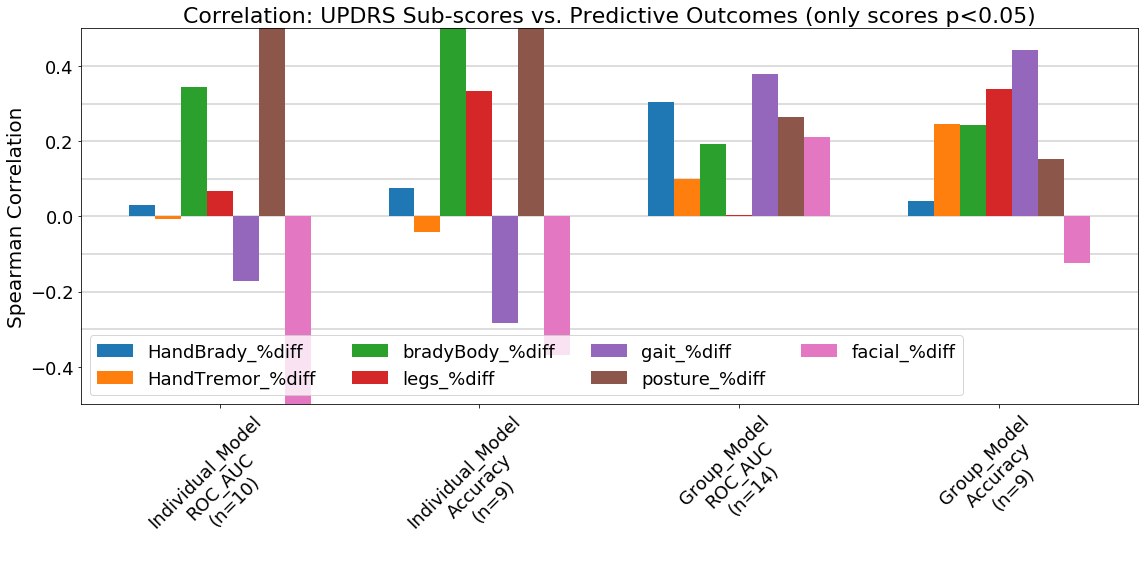

In [202]:
## correlations updrs sub-scores with outcome, new datasplitting analyses

relativeSubScores = ['HandBrady_%diff','HandTremor_%diff','bradyBody_%diff','legs_%diff','gait_%diff','posture_%diff','facial_%diff' ]

metrics = ['ROC_AUC', 'Accuracy']
methods = {'Individual':'ind_',  'Group': 'group_'}

plt.figure(figsize=(16,8))
# create lists with 4 values (2 model * 2 metric) for every updrs-subscore
xtick_list = []
corr_list = {}
for clinVar in relativeSubScores:
    corr_list[clinVar] = []
for method in methods:
    for metric in metrics:
        #only take patients with significant value?
        sign_group = svtable[svtable['%s%s_sign' % (methods[method],metric)] == 1] # change in == 1 for only sign
        xtick_list.append('%s_Model\n%s\n(n=%i)' % (method,metric,sign_group.shape[0]))
        for clinVar in relativeSubScores:
            if method == 'Individual':
                r,p = spearmanr(sign_group[clinVar], sign_group['%s%s_mean' % (methods[method],metric)])
                corr_list[clinVar].append(r)
            elif method == 'Group':
                r,p = spearmanr(sign_group[clinVar], sign_group['%s%s' % (methods[method],metric)])
                corr_list[clinVar].append(r)

x = np.arange(len(xtick_list))

width = 0.1
lw = 0.2
cs = 10
for n,clinVar in enumerate(relativeSubScores):
    plt.bar(x+ 0.1*n, corr_list[clinVar], label=clinVar,  tick_label=xtick_list, capsize=cs,linewidth=lw, width=width, )#color='green' , yerr=stdsOFF, 

plt.ylabel('Spearman Correlation', size=20)
plt.title('Correlation: UPDRS Sub-scores vs. Predictive Outcomes (only scores p<0.05)', size=22)
plt.legend(loc='upper left',fontsize=14)

plt.xticks(np.arange(0.3,len(xtick_list)+.3,1),xtick_list, rotation = 45, fontsize =18)
plt.yticks(fontsize=18)
plt.ylim(-.5,0.5)
plt.legend(loc='lower left',ncol=4,prop={'size': 18})
plt.rcParams["axes.grid"] = False
for h in np.arange(-0.3,0.5,0.1):
    plt.axhline(y=h, zorder=0, color='lightgray')
plt.tight_layout()

# plt.savefig(os.path.join(images_path,'Subscores_vs_Performance_Ind_vs_Group_ONLYSIGN_oct20.png'), dpi=300)

plt.show()       





## Additional Analysis: Influence of amount of Training Data

Only Group Model analyses, per patient:
- start with 1 other patient, 5 random repititions
- 2 other patients, 5 random rep's
- 3 other, etc
- until 19 patients, 1 rep

In [738]:
def amountOfTrainingData(featDict, test_pts, save):
    '''
    Function calculates classification-outcomes for individual model approach with SVM classifier.
    Input: 
    - features-dataframe containing all patients, all 60-sec features, and medication-states.
    - ptList: contains pt names to analyse.
    - save: has to be binary, determining whether outcomes are written to results-folder.
    
    Output: table with mean outcome of individual model per patient (mean is over the 41 possible data-splits),
    including p-values of permutation-test. 
        
    SVM classifier using hyperparameters: C 10, gamma 0.001, kernel rbf.
    
    Discussionpoints: standarisation, per patient, or per combi? Now: per combi.

    '''
    starttime = timer()
    allPts = list(featDict.keys())
    preds = list(featDict[allPts[0]].keys()) # define pred's
    preds.remove('medState')
    
    kfold_mins = 10 # amout of minutes in one k-fold of cv
    
    metrics = ['Accuracy', 'AUC_ROC', ] # define metrics to check significancy for
    outcomeCols = [metr + '_mean' for metr in metrics]
    outcomeCols.extend([metr + '_sd' for metr in metrics])
    ## Preparing data
    # dict to store prediction-ready data per pt
    predDict={}
    # dict to save outcomes per pt
    outcomeDict = {}
    for pt in allPts: # preparing dataframes to train with for all potential patients
        # minSize is shortest length of samples(rows) per pt-side of dataframe, on or off samples
        minSize = min(sum(featDict[pt]['medState']==0),sum(featDict[pt]['medState']==1))
        # df with pred-data per pt
        predDict[pt] = pd.concat([featDict[pt][featDict[pt]['medState']==0][:minSize],featDict[pt][featDict[pt]['medState']==1][:minSize]]).reset_index(drop=True)
    ## Start of analyzing
    for test_pt in test_pts: # calculate every patient separately
        # save outcomes per pt in df, every index is number of used pt's, columns are metrics
        outcomeDict[test_pt] = pd.DataFrame(index=np.arange(1,20), columns=outcomeCols) 
        for nPts in np.arange(1,20): # loops over number of pt's to use for training
            n_reps = 5 # number of repetitions
            if nPts == 19:
                n_reps = 1
            elif nPts == 18:
                n_reps = 2
            elif nPts == 17:
                n_reps = 3
            elif nPts == 16:
                n_reps = 4
            ## start of iteration with one amount of training-pts
            other_pts = list(featDict.keys()).copy() # list with all potential training pt's
            other_pts.remove(test_pt)
            
            acc_list = []
            auc_list = []
            for rep in np.arange(n_reps):
                random.seed(rep*42) # make sure every repetitions has always the same random.seed
                trainPts = random.sample(other_pts,nPts) # takes random sample of n=nPts, from other other_pts
                # make one df of data of trainings patients
                for n,train_pt in enumerate(trainPts):
                    if n == 0:
                        trainData = predDict[train_pt]
                    else:
                        trainData = pd.concat([trainData,predDict[train_pt]]).reset_index(drop=True)
                
                # standarize data 
                scaler = StandardScaler()
                scaler.fit(trainData[trainData['medState']==0][preds]) # standardized only on pre-medication data

                # create x and y dataset for this repetition, of this nr of trainingpts, for this test-patient
                x_train = pd.DataFrame(data = scaler.transform(trainData[preds]), columns = preds)
                y_train = trainData['medState']

                x_test = pd.DataFrame(data = scaler.transform(predDict[test_pt][preds]), columns = preds)
                y_test = predDict[test_pt]['medState']

                ## Performing prediction            
                sv = SVC(C=10, kernel='rbf', gamma=0.001, probability=True) # define classifier as indiv-optimized class
                cv = StratifiedKFold(int(x_train.shape[0]/kfold_mins)) # of folds corresponding to kfold_mins of data pre and post per fold
                sv.fit(x_train, y_train) 
                y_preds = sv.predict(x_test) # predicting
                y_probas = pd.DataFrame(data = sv.predict_proba(x_test), columns = sv.classes_) 
                y_true = y_test
                # calculate and save metrics in lists (per nTrainingPts, per pt), list gets max len 5 (n_reps)
    #             tn, fp, fn, tp = confusion_matrix(y_true,y_preds).ravel()
                acc_list.append(accuracy_score(y_true,y_preds))
                auc_list.append(roc_auc_score(y_true, y_probas[1]))
    #             indiv_outcomes.iloc[n_split]['F1_score'] = f1_score(y_true,y_preds)
    #             indiv_outcomes.iloc[n_split]['Precision'] = precision_score(y_true, y_preds) # precision/PPV
    #             indiv_outcomes.iloc[n_split]['Recall'] = recall_score(y_true, y_preds) # sensitivity/recall/TPR
    #             indiv_outcomes.iloc[n_split]['FPR'] = fp / (fp+tn) # false-alarm rate
                ## end of rep in n_reps
            
            ## all (max) 5 reps are done
            # save outcome means and std dev to outcomePred
            outcomeDict[test_pt].at[nPts,'Accuracy_mean'] = np.mean(acc_list)
            outcomeDict[test_pt].at[nPts,'Accuracy_sd'] = np.std(acc_list)
            outcomeDict[test_pt].at[nPts,'AUC_ROC_mean'] = np.mean(auc_list)
            outcomeDict[test_pt].at[nPts,'AUC_ROC_sd'] = np.std(auc_list)
            # end of nPts iteration, start with one nPts more
        
        print('Test patient',test_pt,'ready')
    
    endtime = timer()
    print('Time passed: %.1f minutes' % ((endtime-starttime)/60)) # gives time in minutes
    
    if save == True:
        totalDF = pd.DataFrame(columns=outcomeDict[test_pts[0]].keys())
        for test_pt in test_pts:
            ptDF = pd.DataFrame(data = outcomeDict[test_pt].values,columns=outcomeDict[test_pt].keys(),
                                index = ['%s_'%test_pt + s for s in amountDataOut[test_pt].index.astype(str)] )
            totalDF = pd.concat([totalDF,ptDF])
        totalDF.to_csv(os.path.join(path,'amountDataResults.csv'))
    
    
    return outcomeDict









In [739]:
allPts = list(features.keys())
testPts = allPts
amountDataOut = amountOfTrainingData(features, testPts, save=False)


Test patient 002 ready
Test patient 012 ready
Test patient 013 ready
Test patient 014 ready
Test patient 015 ready
Test patient 017 ready
Test patient 018 ready
Test patient 023 ready
Test patient 024 ready
Test patient 038 ready
Test patient 039 ready
Test patient 043 ready
Test patient 047 ready
Test patient 051 ready
Test patient 054 ready
Test patient 058 ready
Test patient 063 ready
Test patient 065 ready
Test patient 079 ready
Test patient 090 ready
Time passed: 27.2 minutes


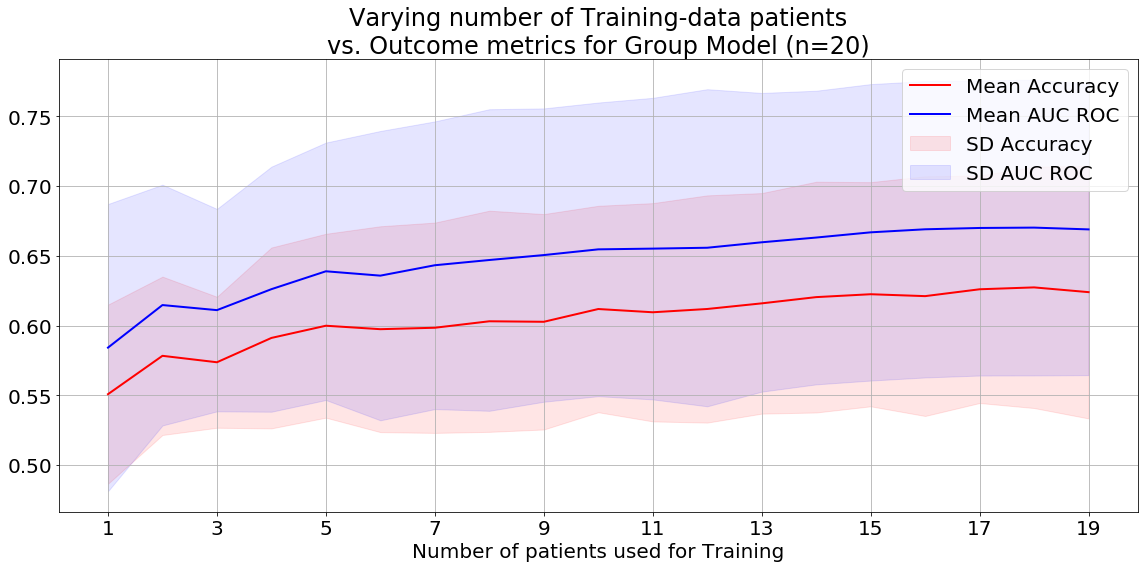

In [586]:
# create dataframe to plot all data
mean_total = pd.DataFrame(index=np.arange(1,20), columns=['Accuracy', 'AUC_ROC', 'Accuracy_sd', 'AUC_ROC_sd',])
fig,ax=plt.subplots(1,1,figsize=(16,8))
for n_pts in np.arange(1,20):
    list_acc = []
    list_auc = []
    # create means for all ttested patients, per number of used trainings patients
    for pt in testPts:
        list_acc.append(amountDataOut[pt].loc[n_pts]['Accuracy_mean'])
        list_auc.append(amountDataOut[pt].loc[n_pts]['AUC_ROC_mean'])
    mean_total.at[n_pts,'Accuracy'] = np.mean(list_acc) # mean and std's over tested patients
    mean_total.at[n_pts,'Accuracy_sd'] = np.std(list_acc)
    mean_total.at[n_pts,'AUC_ROC'] = np.mean(list_auc)
    mean_total.at[n_pts,'AUC_ROC_sd'] = np.std(list_auc)
# make arrays to plot std dev's next to mean line
acc_hg_sd, acc_low_sd, auc_hg_sd, auc_low_sd = [],[],[],[]
for n_pt in np.arange(1,20):
    acc_hg_sd.append(mean_total.loc[n_pt]['Accuracy']+mean_total.loc[n_pt]['Accuracy_sd'])
    acc_low_sd.append(mean_total.loc[n_pt]['Accuracy']-mean_total.loc[n_pt]['Accuracy_sd'])
    auc_hg_sd.append(mean_total.loc[n_pt]['AUC_ROC']+mean_total.loc[n_pt]['AUC_ROC_sd'])
    auc_low_sd.append(mean_total.loc[n_pt]['AUC_ROC']-mean_total.loc[n_pt]['AUC_ROC_sd'])
# plot mean lines of tested patients, for all numbers of training patients (1,2,..,19)
x_plot = mean_total.index
ax.plot(x_plot, mean_total['Accuracy'], label='Mean Accuracy', c='red' , lw=2)
ax.plot(x_plot, mean_total['AUC_ROC'], label='Mean AUC ROC', c='blue' , lw=2)
ax.fill_between(x_plot, acc_hg_sd, acc_low_sd, color='red', alpha=0.1, label='SD Accuracy')
ax.fill_between(x_plot, auc_hg_sd, auc_low_sd, color='blue', alpha=0.1, label='SD AUC ROC')
# config figure
ax.legend(fontsize=20)
ax.set_xlabel('Number of patients used for Training', fontsize=20)
ax.set_xticks(np.arange(1,20,2))
ax.tick_params(labelsize=20)
ax.grid(True, axis='both', which='major')
ax.set_title('Varying number of Training-data patients\nvs. Outcome metrics for Group Model (n=%i)' % len(testPts), fontsize=24)

plt.tight_layout()
plt.savefig(os.path.join(images_path,'Acc_AUC_varying_n_trainPts.png'), dpi=300)
plt.show()



